# TensorFlow 튜토리얼 #23
# 시계열 기반 예측 (Time-Series Prediction)

원저자 [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ) / 번역 곽병권

## 개요

이 튜토리얼은 복수의 여러 도시의 기후 정보를 이용하여 한 도시의 미래 날씨 예보를 시도합니다.

우리는 임의의 길이를 가진 일련의 데이터로 작업 할 것이기 때문에 RNN (Recurrent Neural Network)을 사용할 것입니다.

아래의 내용을 이해하기 위해서는 TensorFlow와 Keras에 익숙해야하며, 튜토리얼 #01과 #03-C, 튜토리얼 #20에서 설명되어 있는 RNN의 기본 사항을 참고하면 좋습니다.

## 위치

여기에서는 1980년~2018년까지의 덴마크 [Denmark](https://en.wikipedia.org/wiki/Denmark)에 있는 다섯개 도시의 기후 정보를 사용합니다:

* **[Aalborg](https://en.wikipedia.org/wiki/Aalborg)** 이곳의 기후 정보는 실제로 공군기지에서 얻게되는데, 여기는 [The Hunter Corps (Jægerkorps)](https://en.wikipedia.org/wiki/Jaeger_Corps_(Denmark)의 본거지 이기도 합니다.
* **[Aarhus](https://en.wikipedia.org/wiki/Aarhus)** 이 도시는 [C++ 발명자-비얀 스트롭스트룹](https://en.wikipedia.org/wiki/Bjarne_Stroustrup)가 연구했고 [Google V8 JavaScript Engine](https://en.wikipedia.org/wiki/Chrome_V8)이 개발된 곳 입니다.
* **[Esbjerg](https://en.wikipedia.org/wiki/Esbjerg)** 은 거대한 낚시 항구를 가지고 있습니다.
* **[Odense](https://en.wikipedia.org/wiki/Odense)** 은 동화작가인 안데르센_[H. C. Andersen](https://en.wikipedia.org/wiki/Hans_Christian_Andersen)이 태어난 도시입니다.
* **[Roskilde](https://en.wikipedia.org/wiki/Roskilde)** 에는 덴마크 왕가의 무덤이 있는 오래된 성당이 있습니다.

## 흐름도

이 튜토리얼에서는 5개 도시의 현재 및 과거 기상 데이터를 바탕으로 향후 24시간 동안 덴마크 "Odense"지역 날씨를 예측하려고 합니다 (아래의 순서도는 2개 도시 만 표시 함).

우리는 임의의 길이를 가진 일련의 데이터로 작업을 해야 하기 때문에 RNN (Recurrent Neural Network)을 사용합니다. 학습 중 우리는 5개 도시 각각에 대해 온도, 압력 등에 대한 20개의 입력 신호가 있는 각 데이터 포인트 또는 관측값이 있는 학습 세트에서 1344데이터 포인트 (8주 = 24 x 7 X 8)의 하위 시퀀스를 사용합니다. 우리는 신경 망을 학습시켜서 내일의 온도, 압력 및 풍속에 대한 3가지 신호를 출력하도록 만들 것 입니다.

## Imports

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

Keras에서 다수의 클래스를 Import 합니다.

In [0]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

이 튜토리얼은 Python 3.6 (Anaconda)와 아래의 패키지 버전으로 개발되었습니다:

In [3]:
tf.__version__

'1.12.0-rc1'

In [4]:
tf.keras.__version__

'2.1.6-tf'

In [5]:
pd.__version__

'0.22.0'

## 데이터 읽어들이기

아래의 코드는 덴마크의 다섯개 도시의 날씨 정보를 자동으로 다운로드 해 줍니다.

원시 날씨 데이터는 원래 [National Climatic Data Center (NCDC), USA] (https://www7.ncdc.noaa.gov/CDO/cdoselect.cmd)에서 가져온 것입니다. 웹 사이트 및 데이터베이스 액세스는 정리되어 있지는 않고 또 곧 변경될 여지가 있습니다. 또한 원시 데이터 파일을 읽어들이기 전에 수동으로 편집해야 했습니다. 따라서 다른 지역의 날씨 데이터를 다운로드 할 계획이 있다면 여러가지 난관이 있을 것을 대비하시기 바랍니다. 아래의 파이썬 모듈은 새로운 날씨 데이터를 사용하고자 하는 경우 유용 할 수있는 기능을 제공하지만 데이터 형식에 맞게 소스 코드를 수정해야 합니다.

In [6]:
import os
work_dir = "/content/TensorFlow-Tutorials/"
if os.getcwd() != work_dir:
  !git clone https://github.com/Steven-A3/TensorFlow-Tutorials.git
os.chdir(work_dir)

import weather

Cloning into 'TensorFlow-Tutorials'...
remote: Enumerating objects: 465, done.
remote: Total 465 (delta 0), reused 0 (delta 0), pack-reused 465
Receiving objects: 100% (465/465), 60.23 MiB | 21.72 MiB/s, done.
Resolving deltas: 100% (248/248), done.


데이터를 다운로드 합니다. 만약 다운로드가 이미 되어 있다면 하지 않습니다. 크기는 35MB입니다.

In [7]:
weather.maybe_download_and_extract()

- Download progress: 100.0%
Download finished. Extracting files.
Done.


데이터 세트에 사용된 도시 목록을 표시합니다.

In [8]:
cities = weather.cities
cities

['Aalborg', 'Aarhus', 'Esbjerg', 'Odense', 'Roskilde']

데이터를 로드하고, 샘플링 간격을 60분 간격으로 조정합니다. 누락된 구간은 선형으로 보간합니다. 이것은 최초 실행에서는 약 30초가 걸리지만 캐시 파일을 사용하므로 한번만 실행됩니다.

In [9]:
%%time
df = weather.load_resampled_data()

CPU times: user 53.6 s, sys: 4.06 s, total: 57.7 s
Wall time: 57.7 s


다음은 가공된 데이터 세트의 상위 다섯개의 행을 표시합니다.

In [10]:
df.head()

Aalborg                                    Aarhus  \
                         Temp     Pressure WindSpeed     WindDir   Temp   
DateTime                                                                  
1980-03-01 11:00:00  5.000000  1007.766667      10.2  280.000000    5.0   
1980-03-01 12:00:00  5.000000  1008.000000      10.3  290.000000    5.0   
1980-03-01 13:00:00  5.000000  1008.066667       9.7  290.000000    5.0   
1980-03-01 14:00:00  4.333333  1008.133333      11.1  283.333333    5.0   
1980-03-01 15:00:00  4.000000  1008.200000      11.3  280.000000    5.0   

                                                     Esbjerg           \
                        Pressure WindSpeed WindDir      Temp Pressure   
DateTime                                                                
1980-03-01 11:00:00  1008.300000      15.4   290.0  6.083333      NaN   
1980-03-01 12:00:00  1008.600000      13.4   280.0  6.583333      NaN   
1980-03-01 13:00:00  1008.433333      15.4   280.0  6.888889      NaN   
1980-03-01 14:00:00  1008.266667      14.9   300.0  6.222222      NaN   
1980-03-01 15:00:00  1008.100000      17.0   290.0  5.555556      NaN   

                                              Odense                          \
                     WindSpeed     WindDir      Temp     Pressure  WindSpeed   
DateTime                                                                       
1980-03-01 11:00:00  12.383333  310.000000  6.142857  1011.066667  12.585714   
1980-03-01 12:00:00  12.883333  310.000000  7.000000  1011.200000  11.300000   
1980-03-01 13:00:00  13.244444  309.444444  7.000000  1011.300000  12.118182   
1980-03-01 14:00:00  12.911111  306.111111  6.857143  1011.400000  12.742857   
1980-03-01 15:00:00  12.577778  302.777778  6.000000  1011.500000  12.400000   

                             Roskilde                                  
                    WindDir      Temp Pressure  WindSpeed     WindDir  
DateTime                                                               
1980-03-01 11:00:00   290.0  5.000000      NaN  11.466667  280.000000  
1980-03-01 12:00:00   290.0  5.000000      NaN  12.466667  280.000000  
1980-03-01 13:00:00   290.0  5.166667      NaN  13.133333  278.333333  
1980-03-01 14:00:00   290.0  5.833333      NaN  12.300000  270.000000  
1980-03-01 15:00:00   290.0  4.833333      NaN  12.300000  270.000000

### 누락된 데이터

Esbjerg와 Roskilde의 두 도시의 데이터에는 아래의 두개의 그래프에서 보이듯이 대기압 정보에 일부 누락된 데이터가 있습니다.

여기에서는 리샘플링 된 데이터를 사용하기 때문에, 누락 된 값이 있는 경우 해당 구간을 인접 값에서 선형으로 보간 된 새 값으로 채 웁니다. 이 값은 그래프상에서는 긴 직선으로 나타납니다.

이것은 신경망을 혼동시킬 수 있습니다. 간단히 하기 위해서, 여기에서는 이 두개의 컬럼을 삭제합니다.

지금은 데이터 축을 삭제하고 진행하지만, 이 데이터 구간이 비교적 짧은 기간의 데이터 만 누락되어 있기 때문에, 다른 모든 입력 신호에서 누락 된 데이터를 생성하는 예측 모델을 만들어 이 데이터를 생성 할 수 있습니다. 그런 다음 생성 된 값을 데이터 세트에 다시 추가하여 간격을 채울 수 있습니다.

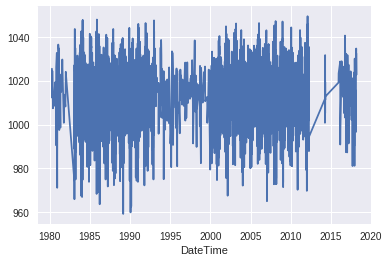

In [11]:
df['Esbjerg']['Pressure'].plot()

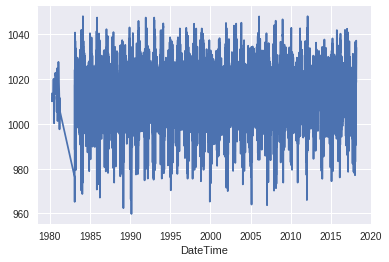

In [12]:
df['Roskilde']['Pressure'].plot()

이 두 신호를 제거하기 전에는 데이터 세트에 20 개의 입력 신호가 있었습니다.

In [13]:
df.values.shape

(333109, 20)

그런 다음 누락 된 데이터가 있는 두 개의 신호를 제거합니다.

In [0]:
df.drop(('Esbjerg', 'Pressure'), axis=1, inplace=True)
df.drop(('Roskilde', 'Pressure'), axis=1, inplace=True)

이제는 데이터에 18개의 입력 신호만 있습니다.

In [15]:
df.values.shape

(333109, 18)

이 두 데이터 열이 실제로 제거되었는지 확인할 수 있습니다.

In [16]:
df.head(1)

Aalborg                                Aarhus           \
                       Temp     Pressure WindSpeed WindDir   Temp Pressure   
DateTime                                                                     
1980-03-01 11:00:00     5.0  1007.766667      10.2   280.0    5.0   1008.3   

                                        Esbjerg                       Odense  \
                    WindSpeed WindDir      Temp  WindSpeed WindDir      Temp   
DateTime                                                                       
1980-03-01 11:00:00      15.4   290.0  6.083333  12.383333   310.0  6.142857   

                                                    Roskilde             \
                        Pressure  WindSpeed WindDir     Temp  WindSpeed   
DateTime                                                                  
1980-03-01 11:00:00  1011.066667  12.585714   290.0      5.0  11.466667   

                             
                    WindDir  
DateTime                     
1980-03-01 11:00:00   280.0

### 데이터 오류

이 데이터에는 몇 가지 오류가 있습니다. 아래 그림에서 볼 수 있듯이 Odense시 온도가 갑자기 거의 50도까지 상승합니다. 하지만, 덴마크에서 측정된 최고 기온은 섭씨 36.4℃도 였고 최저치는 -31.2℃였습니다. 따라서 이것은 분명히 데이터 오류로 볼 수 있습니다. 그렇지만, 이 자습서에서는 데이터 오류를 수정하지 않습니다.

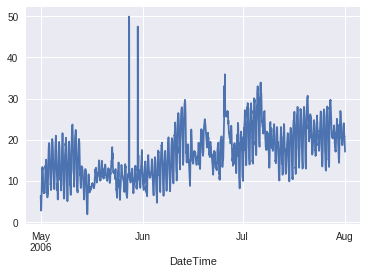

In [17]:
df['Odense']['Temp']['2006-05':'2006-07'].plot()

그 기간 동안 덴마크의 일부 다른 도시의 기온은 불과 10℃에 불과하다는 점을 감안하면 오류일 가능성이 매우 높습니다. 덴마크의 면적을 고려할 때 다른 도시의 기온이 10℃인데, 한 도시가 50℃의 기온을 보이는 것은 불가능하기 때문입니다. 

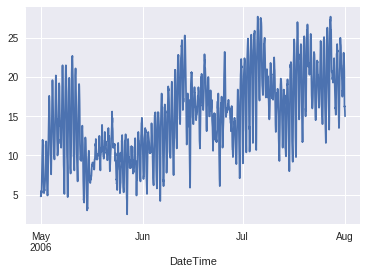

In [18]:
df['Aarhus']['Temp']['2006-05':'2006-07'].plot()

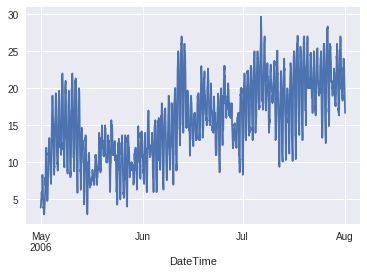

In [19]:
df['Roskilde']['Temp']['2006-05':'2006-07'].plot()

### 데이터 추가

우리는 모델이 예측을 하면서 도움을 받을 수 있도록 데이터에 몇 가지 입력 신호를 추가 할 수 있습니다.

예를 들어 섭씨 10℃의 온도만 주어지면 낮인지 밤인지 여름인지 겨울인지에 따른 온도 측정의 여부를 알 수 없습니다. 이 모델은 비정상적으로 따뜻한 겨울인지, 비정상적으로 추운 여름인지, 또는 주간인지 밤인지 여부를 판단하기에 매우 정확하지 않은 주변 데이터 포인트로부터 이를 추측해야 합니다. 따라서 이 정보를 가지고 있으면 모델이 얼마나 정확하게 다음 출력을 예측할 수 있는지에 큰 차이를 줄 수 있습니다.

데이터 세트에는 각 관측치에 대한 날짜 및 시간 정보가 포함되어 있지만 데이터를 정렬하기 위한 인덱스로만 사용됩니다. 따라서 우리는 일년 중 몇일째 인지(1 ~ 366)와 시간대(0 ~ 23)를 데이터 세트에 별도의 입력 신호로 추가 할 것 입니다.

In [0]:
df['Various', 'Day'] = df.index.dayofyear
df['Various', 'Hour'] = df.index.hour

### 예측을 위한 목표 데이터

우리는 이 도시의 미래 날씨 데이터를 예측 할 것입니다.

In [0]:
target_city = 'Odense'

우리는 이러한 신호를 예측 할 것입니다.

In [0]:
target_names = ['Temp', 'WindSpeed', 'Pressure']

다음은 목표 데이터를 교차 이동할 단계의 수입니다. 우리의 데이터 세트는 매 시간단위의 관찰값으로 재샘플링 되었으므로 24시간 동안 24번의 관찰값이 있습니다.

앞으로 24시간 동안 날씨를 예측하고 싶다면 24시간 간격으로 데이터를 교차 이동하십시오. 미래 7일 날씨를 예측하려면 7 * 24시간 간격으로 데이터를 이동하면 됩니다.

In [0]:
shift_days = 1
shift_steps = shift_days * 24  # Number of hours.

교차 이동을 통해서 새 데이터 프레임을 만듭니다.

**음수 교차 이동임을 주의해서 보세요!**

In [0]:
df_targets = df[target_city][target_names].shift(-shift_steps)

**주의!** 올바른 방향으로 데이터를 이동했는지 다시 확인해야합니다! 우리는 과거가 아니라 미래를 예측하고 싶습니다!

이동 한 데이터 프레임이 약간 혼동스러울 수 있습니다. 데이터를 이동했지만 Pandas는 원본 타임 스탬프는 유지하기 때문입니다. 원본 및 시간 이동 데이터 프레임을 비교하여 데이터 교차 이동이 제대로 이루어졌는지 확인할 수 있습니다.

이것은 원본 데이터 프레임의 첫 번째 `shift_steps + 5` 행입니다.

In [25]:
df[target_city][target_names].head(shift_steps + 5)

,Temp,WindSpeed,Pressure
DateTime,,,
1980-03-01 11:00:00,6.142857,12.585714,1011.066667
1980-03-01 12:00:00,7.000000,11.300000,1011.200000
1980-03-01 13:00:00,7.000000,12.118182,1011.300000
1980-03-01 14:00:00,6.857143,12.742857,1011.400000
1980-03-01 15:00:00,6.000000,12.400000,1011.500000
1980-03-01 16:00:00,4.909091,12.618182,1011.688889
1980-03-01 17:00:00,3.953488,12.646512,1011.877778
1980-03-01 18:00:00,3.674419,11.725581,1012.066667
1980-03-01 19:00:00,3.395349,10.804651,1012.255556


다음은 교차 이동된 데이터 프레임의 처음 5행 입니다. 이것은 시간을 제외하고는 원래 데이터에서 위에 표시된 마지막 5행과 동일해야 합니다.

In [26]:
df_targets.head(5)

,Temp,WindSpeed,Pressure
DateTime,,,
1980-03-01 11:00:00,2.000000,6.828571,1005.833333
1980-03-01 12:00:00,2.000000,8.200000,1005.200000
1980-03-01 13:00:00,0.166667,9.216667,1004.766667
1980-03-01 14:00:00,1.000000,11.885714,1004.333333
1980-03-01 15:00:00,1.000000,12.400000,1003.900000


교차 이동 된 데이터 프레임은 원래 데이터 프레임과 길이가 같지만, 데이터가 거꾸로 이동 했으므로 마지막 관측치는 `NaN`(숫자가 아님)이 됩니다. 왜냐하면 존재하지 않는 데이터를 역방향으로 교차 이동하려고 했기 때문입니다.

In [27]:
df_targets.tail()

,Temp,WindSpeed,Pressure
DateTime,,,
2018-03-01 19:00:00,NaN,NaN,NaN
2018-03-01 20:00:00,NaN,NaN,NaN
2018-03-01 21:00:00,NaN,NaN,NaN
2018-03-01 22:00:00,NaN,NaN,NaN
2018-03-01 23:00:00,NaN,NaN,NaN


### NumPy 배열

지금 우리는 Pandas 데이터 프레임을 신경망에 입력 할 수 있는 NumPy 배열로 변환합니다. 또한 대상 데이터가 이동된 기간에 대해 NaN값을 들어있기 때문에 numpy 배열의 마지막 부분을 제거하고 유효한 데이터만 유지해야 하고 입력 및 출력 데이터에 대해 동일한 배열 모양이 필요합니다.

다음은 입력 신호입니다:

In [0]:
x_data = df.values[0:-shift_steps]

In [29]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (333085, 20)


다음은 출력 신호 (또는 대상 신호)입니다:

In [0]:
y_data = df_targets.values[:-shift_steps]

In [31]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (333085, 3)


이것은 데이터 세트의 관측 수 (일명 데이터 포인트 또는 샘플)입니다:

In [32]:
num_data = len(x_data)
num_data

333085

이것은 학습용 세트에 사용될 데이터 세트의 일부입니다:

In [0]:
train_split = 0.9

이것은 학습용 세트의 관측수 입니다:

In [34]:
num_train = int(train_split * num_data)
num_train

299776

이것은 테스트 세트의 관측 수입니다:

In [35]:
num_test = num_data - num_train
num_test

33309

다음은 학습 및 테스트 세트의 입력 신호입니다:

In [36]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

333085

다음은 학습 및 테스트 세트의 출력신호 입니다:

In [37]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

333085

이것은 입력 신호의 수 입니다:

In [38]:
num_x_signals = x_data.shape[1]
num_x_signals

20

이것은 출력 신호의 수 입니다:

In [39]:
num_y_signals = y_data.shape[1]
num_y_signals

3

### 데이터 구간 조정

데이터 세트에는 다음과 같은 다양한 값이 포함됩니다:

In [40]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -27.0
Max: 1050.8


신경망은 대략 -1에서 1 사이의 값에서 가장 잘 작동하므로 데이터가 신경망에 입력되기 전에 데이터의 값의 범위를 조정해야 합니다. 우리는 `scikit-learn`을 사용할 수 있습니다.

먼저 입력 신호용 스케일러 객체를 만듭니다.

In [0]:
x_scaler = MinMaxScaler()

그런 다음 학습 데이터의 값 범위를 탐지하고 값을 조정합니다.

In [0]:
x_train_scaled = x_scaler.fit_transform(x_train)

작은 반올림 오류는 감안하고, 데이터의 크기는 0에서 1 사이로 조정되었습니다.

In [43]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000002


우리는 테스트 세트의 입력 신호에 대해 동일한 스케일러 객체를 사용합니다.

In [0]:
x_test_scaled = x_scaler.transform(x_test)

목표 데이터는 입력 신호와 동일한 데이터 세트에서 만들어졌습니다. 도시 중 하나에 대한 날씨 데이터를 교차 이동만 시켰기 때문입니다. 그러나, 대상 데이터는 다른 값 범위를 가진 다른 원본에서 가져온 것 일 수 있으므로 대상 데이터에 대해 별도의 스케일러 개체를 만듭니다.

In [0]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

## 데이터 생성기

데이터 세트는 이제 2 차원 numpy 배열로 준비되었습니다. 학습 데이터는 20개의 입력 신호와 3개의 출력 신호로 구성된 약 300,000회의 관측치를 가지고 있습니다.

다음은 입력 및 출력 데이터의 배열 모양입니다:

In [46]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(299776, 20)
(299776, 3)


거의 300k 관측의 전체 시퀀스에 대해 RNN을 훈련하는 대신 다음과 같은 함수를 사용하여 학습 데이터에서 무작위로 선택한 짧은 하위 시퀀스의 배치를 만듭니다.

In [0]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

GPU를 100% 최대한 사용할 수 있도록 최대한 큰 배치 크기를 사용합니다. 사용할 GPU, RAM 및 아래의 'sequence_length' 선택에 따라 이 수를 조정해야 할 수도 있습니다.

In [0]:
batch_size = 256

우리는 1344의 sequence-length를 사용할 것입니다. 이것은 각각의 무작위 순서가 8주 동안의 관찰을 포함한다는 것을 의미합니다. 하나의 단계는 1시간에 해당하므로 24 x 7 시간 간격이 일주일에 해당하고 24 x 7 x 8은 8주에 해당합니다.

In [49]:
sequence_length = 24 * 7 * 8
sequence_length

1344

그런 다음 배치 생성기를 만듭니다.

In [0]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

그런 다음 배치 생성기가 작동하는지 테스트를 해 봅니다.

In [0]:
x_batch, y_batch = next(generator)

이것은 우리에게 256개 시퀀스의 무작위 배치를 제공합니다. 각 시퀀스에는 1344개의 관측치가 있고 각 관측치에는 20개의 입력 신호와 3개의 출력 신호가 있습니다.

In [52]:
print(x_batch.shape)
print(y_batch.shape)

(256, 1344, 20)
(256, 1344, 3)


예를들어 20개의 입력 신호 중 하나를 그래프로 그려보겠습니다.

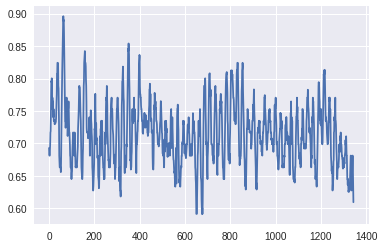

In [53]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

출력 신호 중 하나를 그래프로 그려보겠습니다. 출력 신호는 주어진 20개의 입력 신호를 학습하여 예측해야 값에 해당합니다.

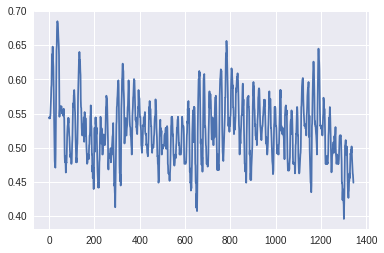

In [54]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

### 검증 세트

이 신경망은 학습 시간이 길지 않으므로 많은 학습 에포크를 수행해 볼 수 있습니다. 하지만, 그렇게 하면 오버피팅이 발생해서 처음 보는 데이터에 대한 예측에 실패할 가능성이 있습니다. 따라서 각 에포크 후에 테스트 세트에서 모델의 성능을 모니터링하고 테스트 세트에서 성능이 향상되는 경우에만 모델의 가중치를 저장합니다.

배치 생성기는 학습 데이터에서 짧은 시퀀스의 배치를 무작위로 선택하여 학습에 사용합니다. 그러나 유효성 검사 데이터의 경우에는 테스트 세트의 전체 시퀀스를 실행하고 해당 전체 시퀀스의 예측 정확도를 측정합니다.

In [0]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

## 순환 신경망(RNN) 만들기

이제 우리는 RNN (Recurrent Neural Network)을 만들 준비가 되었습니다. Keras API는 사용법이 매우 간단하기 때문에 Keras로 구현하도록 하겠습니다. 순환 신경망에 대한 더 자세한 정보는 Keras 튜토리얼의 튜토리얼 #03-C와 튜토리얼 #20을 참조하십시오.

In [0]:
model = Sequential()

이제 Gated Recurrent Unit (GRU)을 네트워크에 추가합니다. 시퀀스의 각 입력 단계마다 512개의 출력을 갖습니다.

모델의 첫 번째 레이어이기 때문에 Keras는 임의의 길이의 시퀀스(`None`으로 표시됨) 배치의 입력 형태를 알아야 하며 각각의 관찰값은 여러 입력 신호를 포함합니다.(`num_x_signals`).

In [0]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

GRU는 일련의 배치 입력에 대해서 512개 값의 출력합니다. 우리는 3개의 출력 신호를 예측하기를 원하기 때문에 512개의 값을 3개의 값으로 매핑하는 완전히 연결된 (또는 dense) 레이어를 추가합니다.

데이터 세트의 출력 신호는 스케일러 객체를 사용하여 0과 1 사이로 제한되었습니다. 그래서 Sigmoid 활성화 함수를 사용하여 신경망의 출력을 제한합니다.이 함수는 출력을 0과 1 사이로 제한합니다.

In [0]:
model.add(Dense(num_y_signals, activation='sigmoid'))

시그모이드 활성화 함수를 사용할 때의 문제점은 학습 데이터와 동일한 범위의 값만 출력 할 수 있다는 점 입니다.

예를 들어, 훈련 데이터의 온도가 -20과 +30도 사이인 경우 스케일러 객체는 -20은 0으로 +30은 1로 매핑합니다. 따라서 신경망의 출력을 0과 1사이로 제한하면 출력은 -20과 +30사이의 온도 값으로 만 매핑 할 수 있습니다.

출력에 선형 활성화 함수를 대신 사용할 수 있습니다. 이렇게 하면 임의의 출력값을 얻을 수 있습니다. 간단한 네트워크 구조로 표준 초기값을 사용하는 경우에는 잘 동작할수도 있지만, 복잡한 네트워크 구조를 이용하여 레이어가 많아지면 학습 중에 NaN 값을 피하기 위해 더 작은 값으로 가중치를 초기화해야 할 수도 있습니다. 이 신경망이 정상동작하도록 하기 위해서는 그러한 실험을 해야 할 수도 있습니다.

In [0]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

### 손실 함수(Loss Function)

최소제곱오차(MSE)를 최소화 할 손실 함수로 사용합니다. 이것은 모델의 출력이 실제 출력 신호와 얼마나 일치하는지를 측정합니다.

학습 초기에 시퀀스의 시작 부분에서 모델은 일부 타임 스텝에 해당하는 입력 신호만 학습했기 때문에 생성된 출력은 매우 부정확 할 수 있습니다. 초기 시간 단계에 손실값을 사용하면 모델이 나중에 출력을 왜곡 할 수 있습니다. 따라서 우리는 모델을 50번의 시간 단계를 "예열 기간"으로 생각하고, 이 단계의 정확도는 신뢰하지 않음으로써 이후 단계의 정확도를 향상시킬 수 있습니다.

In [0]:
warmup_steps = 50

In [0]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

### 모델 컴파일

이것은 우리가 사용할 최적화방법 및 시작 학습률 입니다.

In [0]:
optimizer = RMSprop(lr=1e-3)

그런 다음 Keras 모델을 컴파일하여 학습 준비를 마칩니다.

In [0]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

이것은 두 개의 레이어만 있는 아주 작은 모델입니다. `(None, None, 3)`의 출력 형태는 모델이 임의의 수의 관측치를 갖는 임의의 수의 시퀀스로 배치를 출력하고, 각 관측치에는 3개의 신호가 있음을 의미합니다. 이것은 우리가 예측하기를 원하는 3개의 출력 신호에 해당합니다.

In [64]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         818688    
_________________________________________________________________
dense (Dense)                (None, None, 3)           1539      
Total params: 820,227
Trainable params: 820,227
Non-trainable params: 0
_________________________________________________________________


### Callback Functions

학습을 하는 동안 우리는 체크포인트를 저장하고 진행상황을 TensorBoard에 기록하기 위해서 Keras에 적절한 콜백을 제공합니다.

이것은 학습 중에 체크포인트를 기록하는 콜백입니다.

In [0]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

이는 유효성 검사 집합에서 성능이 악화될 때 최적화를 중지하기 위한 콜백입니다.

In [0]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

이것은 교육 중 TensorBoard 로그를 작성하기 위한 콜백입니다.

In [0]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

이 콜백은 마지막 에포크 이후에 검증 손실이 개선되지 않으면 (`patience = 0`으로 표시됨) 옵티마이저의 학습률을 감소시킵니다. 학습률은 facgtor의 값을 곱하여 감소될 것입니다. 우리는 1e-3의 시작 학습률을 설정했으므로 0.1을 곱하면 1e-4의 학습률이 됩니다. 우리는 학습률을 이보다 낮추기를 원하지 않습니다.

In [0]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [0]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

## 순환 신경망 학습

이제 우리는 신경망을 훈련시킬 수 있습니다.

배치 생성기가 학습 세트의 부분 집합을 무작위로 선택하는 방법을 쓰기 때문에 단일 "에포크"는 학습 세트 전체를 학습하지 않습니다. 대신 우리는 `steps_per_epoch`를 이용하여 선택된 스텝 만큼의 "epoch"가 수 분 안에 처리되도록합니다.

이 설정을 사용하면 GTX 1070에서 각 "에포크"를 처리하는 데 약 2.5분이 걸렸습니다. 14번의 에포크 수행후에 유효성 검사 손실이 5번의 에포크동안 감소하지 않았기 때문에 최적화가 중단되었습니다. 이 최적화 작업을 완료하는 데 약 35분이 걸렸습니다.

또한 손실이 때때로 NaN이 됩니다. 이는 노트북을 다시 시작해서 해결할 수 있습니다. 하지만 신경 네트워크 아키텍처, 학습 속도, 배치 크기, 시퀀스 길이 등으로 인해 발생할 수도 있습니다. 이러한 경우 설정을 수정해야 할 수도 있습니다.

In [0]:
%%time
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
 99/100 [============================>.] - ETA: 4s - loss: 0.0081
Epoch 00001: val_loss improved from inf to 0.00417, saving model to 23_checkpoint.keras
100/100 [==============================] - 443s 4s/step - loss: 0.0081 - val_loss: 0.0042
Epoch 2/20
 99/100 [============================>.] - ETA: 4s - loss: 0.0043
Epoch 00002: val_loss did not improve from 0.00417

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 436s 4s/step - loss: 0.0043 - val_loss: 0.0044
Epoch 3/20
 99/100 [============================>.] - ETA: 4s - loss: 0.0029
Epoch 00003: val_loss improved from 0.00417 to 0.00256, saving model to 23_checkpoint.keras
100/100 [==============================] - 436s 4s/step - loss: 0.0029 - val_loss: 0.0026
Epoch 4/20
 99/100 [============================>.] - ETA: 4s - loss: 0.0028
Epoch 00004: val_loss improved from 0.00256 to 0.00244, saving model to 23_checkpoint.keras
100/100 [========

### 체크포인트 읽어들이기

모델을 훈련 할 때 조기 중단(early-stopping)를 사용하기 때문에 훈련이 중단되기 전에 여러 에포크에 대한 테스트 세트에서 모델의 성능이 악화되었을 가능성이 있습니다. 따라서 우리는 마지막으로 저장된 체크포인트를 다시 로드 합니다. 이 체크포인트는 테스트 세트에서 최고의 정확도를 가진 모델입니다.

In [0]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

## 테스트 세트에 대한 성능

이제 우리는 테스트 세트에서 모델의 성능을 평가할 수 있습니다. 이 함수는 데이터 배치(batch)를 기대하지만, 우리는 단지 하나의 긴 시계열을 테스트 세트에 사용하기 때문에 배열 차원을 확장하여 하나의 시퀀스로 배치를 만듭니다.

In [0]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

In [0]:
print("loss (test-set):", result)

In [0]:
# 만약 여러가지 측정치를 사용한다면 다음의 방법으로 측정할 수 있습니다.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

## 예측값을 만들기

아래의 도움 함수를 통해서 예측된 값과 실제 값을 그래프로 표현해보도록 하겠습니다.

In [0]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

이제 예측 된 출력 신호의 일부를 그래프로 표시할 수 있습니다. 이 그래프가 실제로 무엇을 보여주고 있는지를 이해하는 것이 중요합니다. 실제로는 생각보다 복잡합니다.

이 그래프는 출력 신호만 표시한 것이고 예측을 위해서 학습하는데 사용되었던 20개의 입력 신호를 표시 한것은 아닙니다. 입력 신호와 출력 신호 사이의 시간 이동은 이 플롯에서 고정되어 있습니다. 모델은 **항상** 출력 신호를 예측합니다. 예를 들면, `shift_steps` 변수의 값에 따라서 주어진 시간만큼을 예측할 수 있습니다. 플롯의 x축은 입력 신호의 시간 단계가 예측 모델에게 사용된 양을 표시합니다.

첫 30-50시간 단계에 대한 예측은 그리 정확하지 않습니다. 왜냐하면, 모델이 이 시점에서 예측을 위해서 주어진 데이터를 충분히 파악할 수 없기 때문입니다.

모델은 입력 데이터의 각 시간 단계에 대해 출력 데이터의 단일 시간 단계를 생성하므로 모델이 몇 시간 단계만 예측하는 경우 입력 신호의 내역은 거의 알 수 없으므로 정확한 예측을 하는 것이 불가능합니다. 모델은 예측 된 출력 신호를 사용하기 전에 대략 30-50 시간 단계를 처리하여 "워밍업" 해야합니다.

그래서 우리는 손실함수의 평균 제곱 오차를 계산할 때 50번의 시간 간격에 있는 손실값을 이 "워밍업 기간"동안에 무시한 것 입니다. "워밍업 기간"은 이 플롯에 회색 바탕으로 표시됩니다.

학습 자료의 예부터 시작해 보겠습니다. 이 데이터는 학습 과정에서 본 데이터이므로 이 데이터에서 합리적으로 잘 수행되어야 합니다.

In [0]:
plot_comparison(start_idx=100000, length=1000, train=True)

모델은 온도의 전반적인 진동을 아주 잘 예측하고 있지만 때로는 정점에서는 정확한 값을 예측하지 못합니다. 풍속의 경우 전반적인 진동은 비교적 잘 예측되지만 정점에서는 상당히 부정확합니다. 대기압의 경우 전반적인 곡선 형태가 예측되었지만 약간의 지연이있는 것으로 보이고 예측 된 곡선은 원본 신호의 평활도에 비해 많은 잡음을 나타냅니다.

### 이상한 구간

다음은 학습 세트의 또 다른 예입니다.

일반적으로 하루 동안의 기온은 그리 크게 변하지 않는다는 점에 유의하면서 아래의 그림을 살펴볼 필요가 있습니다. (이 도표는 약 42일을 보여줍니다). 온도는 매일 매일 높낮이를 반복하며 진동합니다. 학습 데이터에서 하루간의 온도 변화는 매우 명확하고 크게 나타납니다. 이 시기가 비정상적으로 안정된 기온인지 또는 어쩌면 데이터 오류가 있는지 여부는 불분명합니다.

In [0]:
plot_comparison(start_idx=200000, length=1000, train=True)

확인해보기 위해서 우리는 유사하게 보이는 리샘플링 된 데이터 세트로부터 직접 이 신호를 그래프로 표시해 보았습니다.

In [0]:
df['Odense']['Temp'][200000:200000+1000].plot()

다시 샘플링되지 않은 원본 데이터와 동일한 기간을 표시 할 수 있습니다. 비슷한 모양입니다.

따라서 이 기간의 온도는 일부에서 비정상적으로 인터넷 날씨 데이터베이스에서 얻은 원시 데이터에 데이터 오류가 있는 것으로 판단이 됩니다.

In [0]:
df_org = weather.load_original_data()
df_org.xs('Odense')['Temp']['2002-12-23':'2003-02-04'].plot()

### 테스트 세트 예제

이제 테스트 세트의 예제를 살펴 보겠습니다. 신경망 모델은 학습중에 이 데이터를 본적이 없습니다.

최고, 최하점은 때로는 부정확하지만 온도는 비교적 잘 예측됩니다.

풍속은 그렇게 잘 예측되지 않았습니다. 일일 진동 주파수는 일치하는 것처럼 보이지만 중앙 수준과 최고점은 상당히 부정확합니다. 예상되는 입력 데이터로부터 풍속을 예측하기 어렵기 때문에 이 모델은 일간 주파수와 대략 중앙 레벨에서 정현파 진동을 출력하는 것을 배웠습니다.

대기압은 실제 시계열보다 지연이 있고 실제 노이즈가 있는 경우를 제외하고는 합리적으로 잘 예측됩니다.

In [0]:
plot_comparison(start_idx=200, length=1000, train=False)

## 결론

이 튜토리얼은 RNN(Recurrent Neural Network)을 사용하여 복수의 입력 신호를 학습하여 여러 시계열을 예측하는 방법을 보여줍니다. 우리는 5개 도시의 날씨 데이터를 사용하여 도시 중 하나의 내일 날씨를 예측했습니다.

그것은 매일 진동 패턴이 존재하는 온도 예측에서는 비교적 잘 작동했지만 정점에서의 예측값은 정확하지 않았습니다. 예측 된 신호에 노이즈가 있고 짧은 지연은 있었지만 대기압도 상당히 잘 예측할 수 있었습니다. 하지만 풍속 예측값은 정확하지 않았습니다.

이 방법을 다른 시계열데이터에 적용할 수는 있지만 데이터에서 상관관계에 대해서 주의해야 합니다. 신경망은 일시적 상관관계를 갖는 데이터의 패턴을 쉽게 파악할수는 있지만, 처음 보는 데이터에 대해서 잘 일반화되지는 않습니다.

우리는 학습을 할 때 *상관관계*가 있을 가능성이 있는 입력 및 출력 데이터를 선택해야 합니다. 교육에 사용할 수있는 많은 데이터가 있어야 과적합 문제를 피할 수 있습니다. 이 튜토리얼에서는 과적합 문제를 피하기 위해서 조기 중단 방법을 사용했습니다.

## 연습문제

TensorFlow로 기술을 향상 시키는데 도움이 될 수있는 몇 가지 제안 사항입니다. TensorFlow를 제대로 사용하는 방법을 배우려면 실습 경험을 쌓는 것이 중요합니다.

변경하기 전에이 노트북을 백업 할 수 있습니다.

* 대상 데이터에서 풍속을 제거하십시오. 그것은 온도와 압력에 대한 예측을 개선합니까?
* 더 낮은 학습률로 더 많은 에포크를 학습해 보세요. 테스트 세트에 대한 정확도가 향상 되었습니까?
* 신경망의 구조를 변경해 보세요. 예를들어, GRU의 갯수를 조정하거나, 계층을 늘려보거나, 완전 연결층을 늘리거나 혹은 앞 뒤로 배치배 볼 수 있습니다.
* 튜토리얼 #19를 참조하여 하이퍼파라미터 최적화를 사용하십시오.
* 배치 생성기에 더 길고 짧은 시퀀스를 사용해 보세요.
* 입력 신호에서 도시 "Odense"를 제거해 보세요.
* 작년의 날씨 데이터를 입력 신호에 추가해 보세요.
* 앞으로 3일 또는 7일 날씨를 예측하는 모델은 얼마나 좋은가?
* 하나의 모델이 예를 들어 한 번에 날씨를 예측할 수 있도록 여러 시간 이동에 대한 출력 신호가 있는 단일 모델을 교육 할 수 있습니까? 예를 들어, 1일단위, 3일단위 혹은 일주일 단위 예측을 한번에 할 수 있을까요?
* 프로그램이 어떻게 작동하는지 친구에게 설명하십시오.

## 라이센스 (MIT)

저작권 (c) 2018 [Magnus Erik Hvass Pedersen] (http://www.hvass-labs.org/)

사용, 복사, 수정, 병합 할 수있는 권한을 포함하되 이에 국한되지 않고 소프트웨어를 취급하기 위해 이 소프트웨어 및 관련 문서 파일 (이하 "소프트웨어")의 사본을 얻는 모든 사람에게 사용 권한이 무료로 부여됩니다. 다음 조건에 따라 소프트웨어의 사본을 게시, 배포, 재 라이센스 및 또는 판매 할 수 있고 소프트웨어를 제공받는 사람에게 허용 할 수 있습니다.

위의 저작권 고지 및 이 허가 고지는 소프트웨어의 모든 사본 또는 상당 부분에 포함되어야합니다.

소프트웨어는 상품성, 특정 목적에의 적합성 및 비 침해에 대한 보증을 포함하여 (단, 이에 한하지 않음) 명시적이거나 묵시적인 어떤 종류의 보증도 없이 "있는 그대로" 제공됩니다. 제작자 또는 저작권 보유자는 소프트웨어 또는 사용과 관련하여 발생했거나 발생했거나 발생했거나 또는 기타 행위로 인해 발생한 청구, 기타 책임에 대해 어떠한 경우에도 책임을 지지 않습니다.